# Zindi Flood Prediction Challenge

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display
import seaborn as sns
import rasterio
import geopandas as gpd
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import Pipeline
from catboost import CatBoostRegressor
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing import MinMaxScaler
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense
from tensorflow.python.keras.wrappers.scikit_learn import KerasRegressor
from keras import backend as K
plt.rcParams['figure.figsize'] = [8, 12]

Using TensorFlow backend.


## Define Requirements
![Image of Floods](MalawiFlooding.jpg)
<br>
### Context
Zindi is a data science competition platform focused on solving Africa’s most pressing problems.The objective of this competition is to build a machine learning model that helps predict the location and extent of floods in southern Malawi. Malawi was hit by major floods in 2015 and again in 2019.
<br>
### Training Data
Training data provided is the flood extent in 2015 of southern Malawi. The map of southern Malawi was divided into 1 km square rectangles. Several features are included as a starting point, but the competition allows gathering of external data from a list of approved sources.
### Target
The target for prediction is flood extent expressed as a fraction of the sq km area (a value between 0 and 1). The test dataset on which the competition leaderboard is ranked is flood extent from the 2019 floods, with the 2015 floods data provided for training.
### Evaluation Metric
The evaluation metric is the Root Mean Square Error of predictions made over all sq km rectangles for 2019 flood extent.

## Gather Data

In [2]:
# Load the provided training data
train = pd.read_csv(os.path.join('data','train.csv'))
train.describe().T

,count,mean,std,min,25%,50%,75%,max
X,16466.0,35.077656,0.392395,34.260000,34.760000,35.050000,35.390000,35.860000
Y,16466.0,-15.813802,0.359789,-16.640000,-16.070000,-15.800000,-15.520000,-15.210000
target_2015,16466.0,0.076609,0.228734,0.000000,0.000000,0.000000,0.000000,1.000000
elevation,16466.0,592.848206,354.790357,45.541444,329.063852,623.000000,751.434813,2803.303645
precip 2014-11-16 - 2014-11-23,16466.0,1.610760,4.225461,0.000000,0.000000,0.000000,1.261848,19.354969
precip 2014-11-23 - 2014-11-30,16466.0,2.502058,8.631846,0.000000,0.000000,0.000000,0.000000,41.023858
precip 2014-11-30 - 2014-12-07,16466.0,1.162076,4.396676,0.000000,0.000000,0.000000,0.000000,22.020803
precip 2014-12-07 - 2014-12-14,16466.0,8.270610,4.263375,1.411452,5.548440,7.941822,10.887235,18.870675
precip 2014-12-14 - 2014-12-21,16466.0,8.892459,3.760052,3.580342,5.905440,8.618390,10.960668,23.044340
precip 2014-12-21 - 2014-12-28,16466.0,9.572821,4.523767,1.254098,6.179885,8.786780,12.670775,21.757828


### Additional Data
Literature review[1] of previous work on flood susceptibility identified eight influential factors : elevation, slope, slope aspect, distance from rivers, average annual rainfall, land use, soil type and lithology.
<br>
Slope and slope aspect are derived below from the elevation data provided. Additional data are taken from [sources] and processed into GeoTIFF rasters which can be sampled at each of the coordinates in the main training dataframe. See notebook below:
## [External Data Import & Processing](External_Data.ipynb)
### Computing Slope & Aspect

In [3]:
# Use pandas' PivotTable function to reshape training dataframe into an (X,Y) array of elevation values
elevations = train.pivot_table(index='X', columns='Y', values='elevation')

# Fill null values (introduced because the area of interest is non-rectangular)
elevations.fillna(method='bfill', inplace=True)
elevations.fillna(method='ffill', inplace=True)

# Convert from dataframe to numpy array
elevations_array = np.array(elevations)

# Use gradient function to compute 1st order partial derivatives of elevation
grads = np.gradient(elevations_array)

# Compute slope as the magnitude of the vector of the two partial derivatives of elevation.
slopes = np.sqrt(grads[0]**2 + grads[1]**2)

# Further derivatives (not selected for final solution)
#curvatures = np.gradient(slopes)
#curvature = np.sqrt(curvatures[0]**2 + curvatures[1]**2)
#plancurvature = curvatures[0]
#profilecurvature = curvatures[1]

# Compute aspect as angle of gradient vector
aspects = np.arctan(grads[1] / grads[0])


def addarray(df, array, name):
    # Takes numpy (X,Y) array and reshapes it into column form to be added to the training dataframe.
    # Returns augmented dataframe.
    array_df = pd.DataFrame(array, index=elevations.index,
                            columns=elevations.columns)
    array_df = array_df.stack(dropna=False).reset_index()
    array_df.rename(columns={array_df.columns[-1]: name}, inplace=True)
    array_df.fillna(array_df[name].mean(), inplace=True)
    df_new = pd.merge(df, array_df, on=['X', 'Y'], how='left')
    return df_new


train = addarray(train, slopes, 'slope')
#train = addarray(train, curvature, 'curvature')
#train = addarray(train, plancurvature, 'plan curvature')
#train = addarray(train, profilecurvature, 'profile curvature')
train = addarray(train, aspects, 'aspect')

## Process Data

### Add Additional Features

In [4]:
def addtif(file, name, clip=False):
    # Takes GeoTIFF file and name of column to be added to dataframes. Samples from the raster at (X, Y) coordinates of each
    # rectangular area, and adds these values to training & test dataframes.
    
    # Clip coordinates for dataset that does not cover full problem area
    if clip == True:
        coords = [(x, np.maximum(y, -16.599))
                  for x, y in zip(train.X, train.Y)]
    else:
        coords = [(x, y) for x, y in zip(train.X, train.Y)]

    # Open the raster and store metadata
    src = rasterio.open(os.path.join('data',file))

    # Sample the raster at every point location and store values in DataFrame
    train[name] = [z[0] for z in src.sample(coords)]


addtif('dtareas.tif', 'water_area_distance', clip=True)
#addtif('flowAccum3.tif', 'flow_accum')
addtif('soilmoisture.tif', 'soil_moisture')
addtif('distanceriver.tif', 'river_distance')

train.river_distance.fillna(train.river_distance.mean(), inplace=True)

### Split out Training & Test Dataframes

In [5]:
# Copy current training dataframe
df = train

# Create lists of 2015 & 2019 precipitation columns
precip_features_2019 = df.filter(like='precip 2019', axis=1).columns
precip_features_2015 = df.filter(like='precip 2014', axis=1).columns.append(
    df.filter(like='precip 2015', axis=1).columns)

# Create new train & test dataframes with only 2015 and 2019 precipitation features, respectively.
train = df[df.columns.difference(precip_features_2019)]
test = df[df.columns.difference(precip_features_2015)].drop(
    'target_2015', axis=1)

# Rename columns in relative timeframe for consistency between training and test column names
new_2015_cols = {}
for col, number in zip(precip_features_2015, range(1, len(precip_features_2015) + 1)):
    if 'precip' in col:
        new_2015_cols[col] = 'week_' + str(number) + '_precip'
new_2019_cols = {}
for col, number in zip(precip_features_2019, range(1, len(precip_features_2019) + 1)):
    if 'precip' in col:
        new_2019_cols[col] = 'week_' + str(number) + '_precip'
train.rename(columns=new_2015_cols, inplace=True)
test.rename(columns=new_2019_cols, inplace=True)

# Save 2015 target
target_2015 = train.target_2015

# Verify training & test columns are consistent using align function
train, test = train.align(test, join='inner', axis=1)

print('Train Dataframe')
display(train.head(1))
print('Test Dataframe')
display(test.head(1))

Train Dataframe


,LC_Type1_mode,Square_ID,X,Y,aspect,elevation,week_1_precip,week_2_precip,week_3_precip,week_4_precip,...,week_12_precip,week_13_precip,week_14_precip,week_15_precip,week_16_precip,week_17_precip,river_distance,slope,soil_moisture,water_area_distance
0,9,4e3c3896-14ce-11ea-bce5-f49634744a41,34.26,-15.91,0.373642,887.764222,0.0,0.0,0.0,14.844025,...,32.878318,8.179804,0.963981,16.659097,3.304466,0.0,14.800764,113.222318,40,112.271991


Test Dataframe


,LC_Type1_mode,Square_ID,X,Y,aspect,elevation,week_1_precip,week_2_precip,week_3_precip,week_4_precip,...,week_12_precip,week_13_precip,week_14_precip,week_15_precip,week_16_precip,week_17_precip,river_distance,slope,soil_moisture,water_area_distance
0,9,4e3c3896-14ce-11ea-bce5-f49634744a41,34.26,-15.91,0.373642,887.764222,12.99262,4.582856,35.037532,4.796012,...,0.0,0.0,0.0,0.0,0.0,0.0,14.800764,113.222318,40,112.271991


### Features Summary

<table>
  <tr>
    <th>Feature</th>
    <th>Description</th>
  </tr>
  <tr>
    <td>Square_ID</td>
    <td>Unique ID for each sq km rectangle</td>
  </tr>
  <tr>
    <td>LC_Type1_mode</td>
    <td>Dominant Land Cover Type (Categorical)</td>
  </tr>
  <tr>
    <td>week_X_precip</td>
    <td>Rainfall data for each rectangle for 18 weeks beginning 2 months before flooding.</td>
  </tr>
  <tr>
    <td>X, Y</td>
        <td>Longitude and latitude (degrees) of centrepoint of rectangle</td>
  </tr>
   <tr>
    <td>elevation</td>
    <td>Mean elevation (m +Sea Level) over the rectangle.</td>
  </tr>
   <tr>
    <td>slope</td>
    <td>Average slope derived from elevation data.</td>
  </tr>
  <tr>
    <td>water_area_distance</td>
    <td>Distance (degrees) to nearest area of water from DIVA-GIS dataset. [DIVA-GIS Inland Water Areas](http://www.diva-gis.org/Data).</td>
  </tr>
      <tr>
    <td>river_distance</td>
    <td>Distance to nearest river in OSM Waterways dataset [MASDAP Waterways Data](http://www.masdap.mw/layers/osm:osm_waterareas)</td>
  </tr>
        <tr>
    <td>soil_moisture</td>
    <td>Survace soil moisture (mm) [NASA Soil Moisture Data](https://developers.google.com/earth-engine/datasets/catalog/NASA_USDA_HSL_SMAP_soil_moisture)</td>
  </tr>
</table>

## Data Visualisation

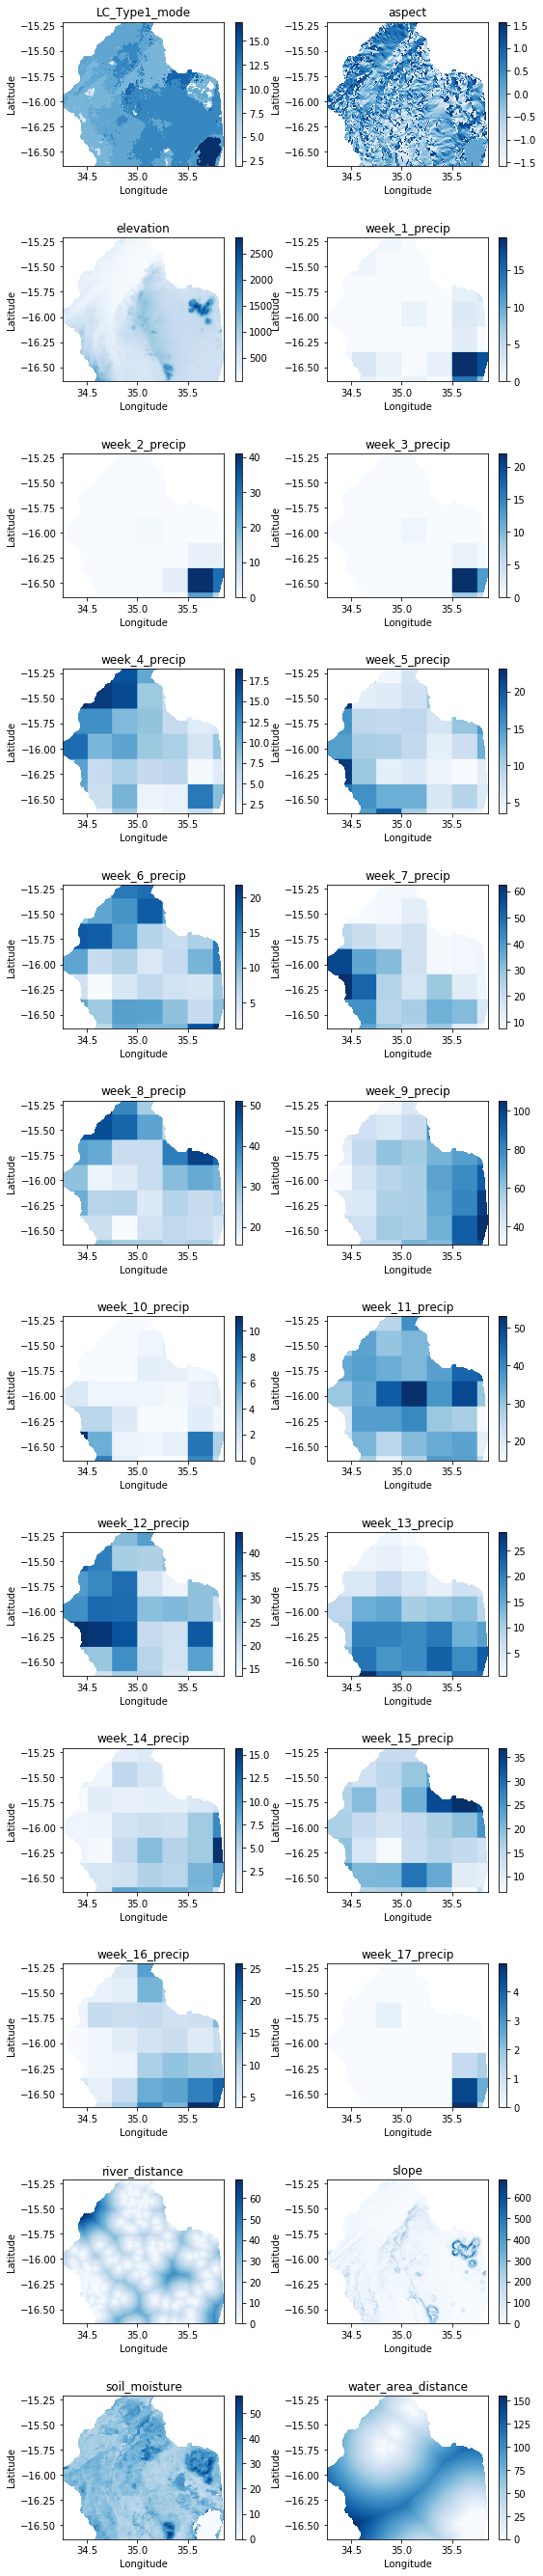

In [6]:
cols = train.drop(['X', 'Y', 'Square_ID'], axis=1).columns
grids = []

for col in cols:
    grid = train.pivot(index='Y', columns='X', values=col)
    grids.append(grid)

fig, axes = plt.subplots(nrows=12, ncols=2, figsize=(9,4*12))
#fig.delaxes(axes[-1,-1])
fig.subplots_adjust(hspace=0.5)

for ax, feature, name in zip(axes.flatten(), grids, cols):
    im = ax.imshow(feature, cmap='Blues', interpolation='nearest', extent=[
           train.X.min(), train.X.max(), train.Y.min(), train.Y.max()])
    ax.set(title=name, xlabel='Longitude', ylabel='Latitude')
    plt.colorbar(im,ax=ax)
plt.show()

Notes:
    
- The precipitation data has a very low spacial resolution.

- There appears to be an anomalous region of heavy rain in the lower left corner of the map. 
On inspection of the LC_Type1_mode map, this corresponds with an area of water.

## Modelling

Previous work [2] indicated that CatBoostRegressor performs well on this dataset, so this was selected as the model alongside a Keras Deep NN for comparison. Cross validation with 10 folds was performed on the training dataset.

In [7]:
# Remove Square_ID for model training
X = train.drop('Square_ID', axis=1)
y = target_2015

# Save features for feature importance analysis
features = X.columns

# Convert y into numpy array for scaling
y = np.reshape(np.array(y), (-1, 1))
scaler_y = MinMaxScaler()
print(scaler_y.fit(y))
y = scaler_y.transform(y)

MinMaxScaler(copy=True, feature_range=(0, 1))


### CatBoostRegressor

In [8]:
cbr = CatBoostRegressor(logging_level='Silent',
                          cat_features=['LC_Type1_mode'])
#kfold = KFold(n_splits=10, random_state=101)
#scores = cross_val_score(
#    cbr, X, y, scoring='neg_mean_squared_error', cv=kfold)
#rmse = np.sqrt(scores * -1)
#print(rmse.mean(), rmse.std())

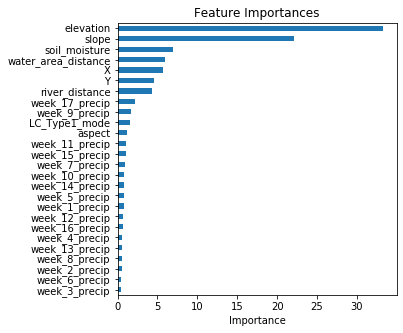

In [9]:
cbr.fit(X, y)
importances = pd.DataFrame(cbr.feature_importances_, index=features, columns=['Importance'])
ax = importances.sort_values(by='Importance').plot(kind='barh', figsize=(5,5), legend=None)
ax.set_title('Feature Importances')
ax.set_xlabel('Importance')
plt.show()

The most predictive feature is elevation, followed by slope which is its derivative.

### Neural Network

In [10]:
def root_mean_squared_error(y_true, y_pred):
    # Root mean squared error for evaluation metric
    return K.sqrt(K.mean(K.square(y_pred - y_true)))

def nn():
    model = Sequential()
    model.add(Dense(100, input_shape=(X.shape[1],), kernel_initializer='normal', activation='relu'))
    model.add(Dense(50, activation='relu'))
    model.add(Dense(25, activation='relu'))
    model.add(Dense(1, activation='linear'))
    model.compile(loss='mse', optimizer='adam', metrics=[root_mean_squared_error])
    return model

nn().summary()

# Create regressor with Keras model using Scikit-learn regressor API
kr = KerasRegressor(build_fn=nn, nb_epoch=60, batch_size=200, verbose=False)

# While decision tree based methods are robust to difference in scale between features, neural networks benefit from feature
# scaling so that input variables are in the range that activation functions lie in.
scaler_X = MinMaxScaler()

# Add scalar to a pipeline with the model, to avoid having to scale the input to CatBoost which introduces problems
# with categorical features.
nnr = Pipeline([
        ('scale', scaler_X),
        ('kr', kr)])

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 100)               2700      
_________________________________________________________________
dense_1 (Dense)              (None, 50)                5050      
_________________________________________________________________
dense_2 (Dense)              (None, 25)                1275      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 26        
Total params: 9,051
Trainable params: 9,051
Non-trainable params: 0
_________________________________________________________________


### Cross-validation

In [11]:
%%time

models = [cbr, nnr]
names = ['CatBoostRegressor', 'Keras NN']

n_folds = 10
kfold = KFold(n_splits=n_folds, random_state=41)

results = pd.DataFrame(columns=names)

for model, name in zip(models, names):
    # Perform KFold crossvalidation, outputting array of scores
    scores = cross_val_score(
        model, X, y, scoring='neg_mean_squared_error', cv=kfold)

    # Convert negative mean squared error to root mean squared error
    rmses = np.sqrt(scores * -1)

    # Add to results dataframe
    for fold in range(n_folds):
        results.loc['Fold ' + str(fold + 1), name] = rmses[fold]
    results.loc['Mean', name] = rmses.mean()
    results.loc['STD', name] = rmses.std()

results

Instructions for updating:
Use tf.cast instead.
CPU times: user 9min, sys: 1min 5s, total: 10min 6s
Wall time: 4min 1s


,CatBoostRegressor,Keras NN
Fold 1,0.0889751,0.0869003
Fold 2,0.0530496,0.083598
Fold 3,0.0991118,0.107279
Fold 4,0.161185,0.235595
Fold 5,0.163304,0.273913
Fold 6,0.120824,0.192793
Fold 7,0.0481402,0.109468
Fold 8,0.132885,0.108479
Fold 9,0.246794,0.297313
Fold 10,0.190043,0.280922


The CatBoost gradient boosted decision tree model clearly outperforms the neural network with this architecture. 

## Final Training & Submission

In [14]:
models = [cbr, nnr]
names = ['catboost', 'keras']

# Create model test input dataframe
X_test = test.drop('Square_ID', axis = 1)

# Output submission file for each model
for model, model_name in zip(models, names):
  regressor = model
  regressor.fit(X, y)
  predictions  = regressor.predict(X_test)
  submission_df = pd.DataFrame({'Square_ID': test.Square_ID, 'target_2019': predictions})
  submission_df.to_csv(os.path.join('submissions', model_name + '.csv'), index = False)

## References

[1] Janizadeh, S. (2013). Prediction Success of Machine Learning Methods for
Flash Flood Susceptibility Mapping in the Tafresh Watershed, Iran. Sustainability, MDPI, Open Access Journal, vol. 11(19), pages 1-19, September.

[2] [Moruri, D. (2019). Starter Code for Flood Prediction in Malawi]('https://github.com/DariusTheGeek/Flood-Prediction-in-Malawi--Zindi-Competition/blob/master/Malawi_Flood_Prediction__starter_code__by_DariusMoruri.ipynb')